In [ ]:
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy import signal

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data_dir = "/Users/trevoryu/Code/syde_599/data/norm_fog_data/"
data_dir = 'drive/MyDrive/599_project_data/norm_fog_data/'

data_files = glob.glob(data_dir + "*.csv")
len(data_files)

56

# Load the data

In [ ]:
WINDOW_SIZE = 650
WINDOW_STEP = 200

train_X = []
train_Y = []
test_X = []
test_Y = []

for file in data_files:
    print(file)
    path_parts = file.split('/')
    patient_num = path_parts[-1].split('_')[0]
    
    data = np.loadtxt(file, delimiter=",", skiprows=1)
    # Timestamp is in col 0, labels are in col 1
    # Data is in cols 2 to end
    y = data[:, 1]
    x = data[:, 2:]
    y[y<0] = 0
    y[y>0] = 1
    print(y.sum())
    # Remove both waist and right shank columns since test data is missing there
    #channels_to_remove = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]  # These are channel inds AFTER removing timestamp and labels
    #x = np.delete(x, channels_to_remove, axis=1)


    # Split into non-overlapping windows
    # Don't use the last bit of data that doesn't fill a whole window
    n_windows = y.size // WINDOW_SIZE
    end = WINDOW_SIZE * n_windows
    x = x[:end, :]  # (n_samples, d)
    y = y[:end]

    # Reshape into (n_windows, window_size, d)
    #x = x.reshape(n_windows, WINDOW_SIZE, -1)
    #y = y.reshape(n_windows, WINDOW_SIZE)
    # Split into overlapping windows
    x = np.lib.stride_tricks.sliding_window_view(x, WINDOW_SIZE, axis=0)[::WINDOW_STEP]
    y = np.lib.stride_tricks.sliding_window_view(y, WINDOW_SIZE, axis=0)[::WINDOW_STEP]

    x = x.transpose(0,2,1)
    
    
    if patient_num in ('001', '009', '010'):
        test_X.append(x)
        test_Y.append(y)
    else:
        train_X.append(x)
        train_Y.append(y)

drive/MyDrive/599_project_data/norm_fog_data/001_task_1.csv
65500.0
drive/MyDrive/599_project_data/norm_fog_data/001_task_3.csv
0.0
drive/MyDrive/599_project_data/norm_fog_data/001_task_2.csv
64500.0
drive/MyDrive/599_project_data/norm_fog_data/001_task_4.csv
0.0
drive/MyDrive/599_project_data/norm_fog_data/002_task_1.csv
0.0
drive/MyDrive/599_project_data/norm_fog_data/002_task_2.csv
0.0
drive/MyDrive/599_project_data/norm_fog_data/002_task_3.csv
0.0
drive/MyDrive/599_project_data/norm_fog_data/002_task_4.csv
1500.0
drive/MyDrive/599_project_data/norm_fog_data/003_task_1.csv
588000.0
drive/MyDrive/599_project_data/norm_fog_data/003_task_2.csv
237000.0
drive/MyDrive/599_project_data/norm_fog_data/003_task_3.csv
26500.0
drive/MyDrive/599_project_data/norm_fog_data/003_task_4.csv
26500.0
drive/MyDrive/599_project_data/norm_fog_data/004_task_1.csv
0.0
drive/MyDrive/599_project_data/norm_fog_data/004_task_2.csv
60000.0
drive/MyDrive/599_project_data/norm_fog_data/004_task_3.csv
0.0
drive/M

In [ ]:
train_X = np.concatenate(train_X, axis=0)
train_Y = np.concatenate(train_Y, axis=0)

test_X = np.concatenate(test_X, axis=0)
test_Y = np.concatenate(test_Y, axis=0)

# Example of augmentation applied

In [ ]:
train_X.shape

(22994, 650, 30)

In [ ]:
train_X.shape

(22994, 650, 30)

In [ ]:
y = train_X[0, :, 0]

In [ ]:
y_stretch = signal.resample(y, int(len(y) * 1.1))
y_squeeze = signal.resample(y, int(len(y) * 0.9))
y_shrink = y * 0.8
y_scaled = y * 1.2

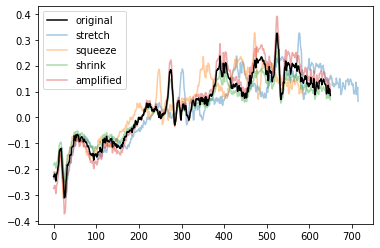

In [ ]:
plt.plot(y, label="original", zorder=4, c='k')
plt.plot(y_stretch, label="stretch", alpha=0.4)
plt.plot(y_squeeze, label="squeeze", alpha=0.4)
plt.plot(y_shrink, label="shrink", alpha=0.4)
plt.plot(y_scaled, label="amplified", alpha=0.4)
plt.legend()
plt.show()

In [ ]:
# Build dataset, dataloader, collate function

In [ ]:
class FoGDataset(torch.utils.data.Dataset):
    def __init__(self, data_x, data_y):
        """
        Parameters:
        -----------
        data_x: np.ndarray of shape (num_samples, window_size, num_features) which contains data features for FoG
        data_y: np.ndarray of shape (num_samples, window_size) which contains binary labels for FoG
        """
        super().__init__()
        self.data_x = data_x
        self.data_y = data_y

    def __len__(self):
        return self.data_x.shape[0]

    def __getitem__(self, index):
        """Returns tuple of (data, label) at index"""
        inputs = self.data_x[index, :, :]
        labels = self.data_y[index, :]
        return inputs, labels


class FoGDataAugment:
    """
    Collate function to apply random time stretch/squeeze and signal shrink/scale
    Apply stretch/squeeze to the time dimension by resampling and truncating to out_samples
        The lower bound of stretch must satisfy (lb * len(input)) > out_samples
    """
    def __init__(self, out_samples=512, p=0.5, stretch=(0.8, 1.2), scale=(0.8, 1.2)):
        """
        Parameters:
        -----------
        p: float between [0, 1], probability of applying each the stretch and scale transform independently
        strech: tuple of float, upper and lower bound on time stretch factor
        scale: tuple of float, upper and lower bound on signal scale factor
        """
        self.p = p
        self.stretch = stretch
        self.scale = scale
        self.out_samples = out_samples
    
    def _reduce_labels(self, y):
        """If there is a 1 in the label, then return 1"""
        return np.any(y == 1, axis=-1).astype(int)

    def _random_crop(self, inputs, labels):
        """Apply a random crop of the signal of length self.out_samples to both inputs and labels"""
        n, d = inputs.shape
        max_offset = n - self.out_samples
        offset = np.random.choice(max_offset)
        inds = slice(offset, offset + self.out_samples)
        return inputs[inds, :], labels[inds]

    def __call__(self, data):
        """
        Parameters:
        -----------
        data: list of tuple of (inputs, labels) of length batch_size
            inputs: np.ndarray, dimensions (n_samples, n_channels), signal data
            labels: np.ndarray, dimensions (n_samples,), binary label vector for the signal data

        Returns:
        --------
        (inputs, labels): augmented signal data, reduced labels
        """
        x = []
        y = []
        for (inputs, labels) in data:
            n, d = inputs.shape
            assert (self.stretch[0] * n) >= self.out_samples, f"input size {n} must be greater than {int(self.out_samples / self.stretch[0])} to apply augmentation"

            # Randomly apply time stretch
            if np.random.binomial(1, self.p) != 0:
                lb, ub = self.stretch
                stretch = np.random.uniform(lb, ub)
                inputs = signal.resample(inputs, int(n * stretch), axis=0)  # Resample the time (n_samples) axis
            if np.random.binomial(1, self.p) != 0:
                lb, ub = self.scale
                scale = np.random.uniform(lb, ub)
                inputs = scale * inputs  # Scale all channels equally
            
            # Apply random crop to self.out_size on both inputs and labels
            inputs, labels = self._random_crop(inputs, labels)

            labels = self._reduce_labels(labels)
            x.append(inputs)
            y.append(labels)
        collated_inputs = torch.tensor(x, dtype=torch.float32)
        collated_labels = torch.tensor(y, dtype=torch.float32)
        return collated_inputs, collated_labels

In [ ]:
train_dataset = FoGDataset(train_X, train_Y)
test_dataset = FoGDataset(test_X, test_Y)

augment_fn = FoGDataAugment(out_samples=512)
test_augment = FoGDataAugment(out_samples=512, p=0)

BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=augment_fn, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=test_augment)

In [ ]:
del train_X, train_Y, test_X, test_Y, train_dataset, test_dataset

# Define model

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, n_layers=3, in_features=30, d_model=128, n_heads=8, dropout=0.1):
        super().__init__()
        self.d_model = d_model

        self.input_transform = nn.Linear(in_features, d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dropout=dropout,
            dim_feedforward=4*d_model,
            activation="gelu",
            batch_first=True,
            norm_first=True)

        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=n_layers)
        self.layer_norm = nn.LayerNorm(d_model)

        # We'll just make a prediction on the features of the first and last sequence point
        self.classifier = nn.Linear(d_model * 2, 1)
    
    def forward(self, x):
        x = self.input_transform(x)
        x = self.encoder(x)
        x = self.layer_norm(x)

        x = x[:, [0, -1], :].reshape(-1, 2 * self.d_model)
        x = self.classifier(x)
        return x

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, fc_dim, bidirectional):
        super(LSTMModel, self).__init__()

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=bidirection
        )

        # Fully connected layer
        self.fc = nn.Linear(fc_dim, output_dim)

    def forward(self, x):

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x)
        
        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out.flatten(start_dim=-2))

        return out

In [ ]:
class CNNLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, fc_dim, bidirection):
        super(CNNLSTMModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=30, out_channels=64, kernel_size=4)
        self.mp = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=64,out_channels=32,kernel_size=4)


          # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=bidirection
        )

        # Fully connected layer
        self.fc1 = nn.Linear(fc_dim, 128)
        self.fc2 = nn.Linear(128, 1)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
       
        out = self.conv1(x.transpose(1,2))
        out = self.mp(out)
        #out = self.conv2(out)
        #out = self.mp(out)
        
        #out = self.conv2(out)
        #out = self.mp(out)
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(out.transpose(1,2))
        
        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc1(out.flatten(start_dim=-2))
        out = self.fc2(out)
        #out = self.fc3(out)

        return out

In [ ]:
class CNNLSTM(nn.Module):
    def __init__(self, input_features=30, dropout_prob=0.5, padding = 'valid', mp=2, pool='max', input_dim=1, hidden_dim=1, layer_dim=1, output_dim=1, fc_dim=1, bidirection=True):
        super(CNNLSTM, self).__init__()

        self.conv1 = nn.Conv1d(input_features, 32, kernel_size=32, stride=2)
        self.mp = nn.MaxPool1d(mp, stride=mp)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=16)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=8)

        self.conv4 = nn.Conv1d(128, 1, kernel_size=4)
        self.dropout = nn.Dropout(dropout_prob)

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional=bidirection
        )

        # Fully connected layer
        self.fc = nn.Linear(fc_dim, output_dim)


    def forward(self, x):
        x = self.conv1(x.transpose(1,2))
        # print(x.shape)
        x = F.relu(x)
        x = self.mp(x)
        #print(x.shape)
        x = self.conv2(x)
        # print(x.shape)
        x = F.relu(x)
        x = self.mp(x)

        x = self.conv3(x)
        # print(x.shape)
        x = F.relu(x)
        
        x = self.conv4(x)
        # print(x.shape)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        
        x, _ = self.lstm(x)
        
        x = self.fc(x)
        return x

# Training

In [ ]:
def train(model, dataloader, optimizer, criterion, epoch, logging_steps=20, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model.train()
    total_loss = 0
    correct = 0
    loss_history = []
    for i, (inputs, targets) in tqdm(enumerate(dataloader)):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        outputs = outputs.flatten()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss
        loss_history.append(loss.item())
        preds = torch.round(torch.sigmoid(outputs))
        correct += torch.sum(preds == targets).detach().cpu()

        if i % logging_steps == 0:
            print(f'Epoch: {epoch} ({i}/{len(dataloader)}) Training loss: {loss}')

    accuracy = correct / (dataloader.batch_size * len(dataloader))
    print(f'Epoch {epoch} done. Training loss: {total_loss/len(dataloader)} Training accuracy: {accuracy}')
    return accuracy, total_loss/len(dataloader), loss_history

In [ ]:
def evaluate(model, dataloader, criterion, epoch, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (inputs, targets) in tqdm(enumerate(dataloader)):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            outputs = outputs.flatten()
            loss = criterion(outputs, targets)

            total_loss += loss
            preds = torch.round(torch.sigmoid(outputs))
            
            correct += torch.sum(preds == targets).detach().cpu()

        accuracy = correct / (dataloader.batch_size * len(dataloader))
        print(f'Epoch {epoch} done. Eval loss: {total_loss/len(dataloader)} Eval accuracy: {accuracy}')
    return accuracy, total_loss/len(dataloader)

In [ ]:
# input_dim = 42
# hidden_dim = 4 
# layer_dim = 1
# output_dim = 1 
# dropout_prob = 0.5
# fc_dim = 8
# bidirection = True
# model = CNNLSTM(input_features=30, dropout_prob=0.5, padding = 'valid', mp=2, pool='max', input_dim=input_dim, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=output_dim, fc_dim=fc_dim, bidirection=bidirection)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
# criterion = nn.BCEWithLogitsLoss()
# EPOCHS = 10

# loss_history = []
# train_acc_history = []
# eval_acc_history = []
# eval_loss_history = []
# for epoch in range(EPOCHS):
#     train_acc, train_loss, history = train(model, train_loader, optimizer, criterion, epoch)
#     eval_acc, eval_loss = evaluate(model, test_loader, criterion, epoch)
    
#     loss_history.extend(history)
#     eval_loss_history.append(eval_loss)
#     train_acc_history.append(train_acc)
#     eval_acc_history.append(eval_acc)
    

In [ ]:
# made running the model a function to work with optuna

def run(params=None):
    if params['pool_size'] == 1:
        input_dim = 216
    elif params['pool_size'] == 2:
        input_dim = 42
    else:
        input_dim = 11
    if params['bidirectional'] == 'True':
        bidirection = True
    else:
        bidirection = False
    hidden_dim = 4 
    layer_dim = 1
    output_dim = 1 
    dropout_prob = 0.5
    fc_dim = 8
    model = CNNLSTM(input_features=30, dropout_prob=params['dropout'], padding=params['padding'], mp=params['pool_size'], pool=params['pooling'], input_dim=input_dim, hidden_dim=hidden_dim, layer_dim=layer_dim, output_dim=output_dim, fc_dim=fc_dim, bidirection=bidirection)
    if params:
        print(params)
        optimizer = getattr(optim, params['optimizer'])(model.parameters(), lr= params['learning_rate'], weight_decay=params['weight_decay'])
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
    criterion = nn.BCEWithLogitsLoss()
    EPOCHS = params['epochs']

    loss_history = []
    train_acc_history = []
    eval_acc_history = []
    eval_loss_history = []
    for epoch in range(EPOCHS):
        train_acc, train_loss, history = train(model, train_loader, optimizer, criterion, epoch)
        eval_acc, eval_loss = evaluate(model, test_loader, criterion, epoch)
        
        loss_history.extend(history)
        eval_loss_history.append(eval_loss)
        train_acc_history.append(train_acc)
        eval_acc_history.append(eval_acc)
    
    return eval_acc_history[-1]

# run()

In [ ]:
# included this as google colab doesn't have optuna by default
!pip install optuna

In [ ]:
# hyperparameter optimization using optuna

import optuna
from optuna import trial

def objective(trial):

    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-2),
              'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
              'padding': trial.suggest_categorical("padding", ["valid", "same"]),
              'pooling': trial.suggest_categorical("pooling", ["max", "avg"]),
              'pool_size': trial.suggest_int("pool_size", 1, 3),
              'dropout': trial.suggest_float("dropout", 0.2, 0.8),
              'weight_decay': trial.suggest_loguniform('weight_decay', 1e-4, 1e-2),
              'epochs': trial.suggest_int("epochs", 3, 15),
              'bidirectional': trial.suggest_categorical("bidirectional", ["True", "False"]),
              # 'batch_size': trial.suggest_int("batch_size", 1, 101, step=10), 
              # 'num_channel': trial.suggest_int("num_channel", 10, 100),
              # 'kernel_size': trial.suggest_int("kernel_size", 1, 3),
              }
    # batch_size excluded so we don't need to process data every time
    # num_channel and kernel_size excluded to make data sizes easier to deal with/nicer in the
    # convolution channels. Can definitely be added, just let me know if we want this.

    accuracy = run(params)

    return accuracy

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=30)
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
best_trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-12-01 19:39:16,695] A new study created in memory with name: no-name-3a94424a-a2bf-49f5-8015-1b9d943c6b86
<ipython-input-74-df2d14e0ce98>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-2),
<ipython-input-74-df2d14e0ce98>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'weight_decay': trial.suggest_loguniform('weight_decay', 1e-4, 1e-2),
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3725746278610358

{'learning_rate': 0.009037022028642632, 'optimizer': 'SGD', 'padding': 'valid', 'pooling': 'max', 'pool_size': 1, 'dropout': 0.3725746278610358, 'weight_decay': 0.00026964639785669113, 'epochs': 3}


1it [00:00,  8.31it/s]

Epoch: 0 (0/360) Training loss: 0.6985577940940857


22it [00:02,  8.49it/s]

Epoch: 0 (20/360) Training loss: 0.6934260725975037


42it [00:05,  8.13it/s]

Epoch: 0 (40/360) Training loss: 0.6947288513183594


62it [00:07,  8.32it/s]

Epoch: 0 (60/360) Training loss: 0.6867790222167969


82it [00:09,  8.20it/s]

Epoch: 0 (80/360) Training loss: 0.693064272403717


102it [00:12,  8.51it/s]

Epoch: 0 (100/360) Training loss: 0.6959656476974487


122it [00:14,  8.36it/s]

Epoch: 0 (120/360) Training loss: 0.6938598155975342


142it [00:17,  8.15it/s]

Epoch: 0 (140/360) Training loss: 0.6944568753242493


162it [00:19,  7.85it/s]

Epoch: 0 (160/360) Training loss: 0.6948206424713135


182it [00:22,  7.89it/s]

Epoch: 0 (180/360) Training loss: 0.6939487457275391


202it [00:24,  8.23it/s]

Epoch: 0 (200/360) Training loss: 0.6971970796585083


222it [00:26,  8.41it/s]

Epoch: 0 (220/360) Training loss: 0.6926255226135254


242it [00:29,  8.14it/s]

Epoch: 0 (240/360) Training loss: 0.6901466250419617


262it [00:31,  8.38it/s]

Epoch: 0 (260/360) Training loss: 0.6976877450942993


282it [00:34,  8.36it/s]

Epoch: 0 (280/360) Training loss: 0.6895184516906738


302it [00:36,  7.96it/s]

Epoch: 0 (300/360) Training loss: 0.6985476613044739


322it [00:39,  8.36it/s]

Epoch: 0 (320/360) Training loss: 0.691952109336853


342it [00:41,  8.44it/s]

Epoch: 0 (340/360) Training loss: 0.6885769367218018


360it [00:43,  8.23it/s]


Epoch 0 done. Training loss: 0.6931660175323486 Training accuracy: 0.5092447996139526


123it [00:13,  9.13it/s]


Epoch 0 done. Eval loss: 0.6838470697402954 Eval accuracy: 0.6006097793579102


1it [00:00,  8.30it/s]

Epoch: 1 (0/360) Training loss: 0.6964852213859558


22it [00:02,  8.18it/s]

Epoch: 1 (20/360) Training loss: 0.6942739486694336


42it [00:05,  8.12it/s]

Epoch: 1 (40/360) Training loss: 0.6960006356239319


62it [00:07,  8.08it/s]

Epoch: 1 (60/360) Training loss: 0.6872739791870117


82it [00:10,  8.05it/s]

Epoch: 1 (80/360) Training loss: 0.692438006401062


102it [00:12,  8.35it/s]

Epoch: 1 (100/360) Training loss: 0.6898894309997559


122it [00:14,  8.11it/s]

Epoch: 1 (120/360) Training loss: 0.6902922987937927


142it [00:17,  7.95it/s]

Epoch: 1 (140/360) Training loss: 0.6931681632995605


162it [00:19,  8.30it/s]

Epoch: 1 (160/360) Training loss: 0.6875749826431274


182it [00:22,  8.56it/s]

Epoch: 1 (180/360) Training loss: 0.6843239068984985


202it [00:24,  8.20it/s]

Epoch: 1 (200/360) Training loss: 0.6933963298797607


222it [00:26,  8.36it/s]

Epoch: 1 (220/360) Training loss: 0.6934818625450134


242it [00:29,  8.31it/s]

Epoch: 1 (240/360) Training loss: 0.6942613124847412


262it [00:31,  8.41it/s]

Epoch: 1 (260/360) Training loss: 0.6954702138900757


282it [00:34,  8.07it/s]

Epoch: 1 (280/360) Training loss: 0.6946307420730591


302it [00:36,  8.38it/s]

Epoch: 1 (300/360) Training loss: 0.6882839202880859


322it [00:38,  7.82it/s]

Epoch: 1 (320/360) Training loss: 0.6900674700737


342it [00:41,  8.32it/s]

Epoch: 1 (340/360) Training loss: 0.6833179593086243


360it [00:43,  8.27it/s]


Epoch 1 done. Training loss: 0.6914480328559875 Training accuracy: 0.5202257037162781


123it [00:13,  9.38it/s]


Epoch 1 done. Eval loss: 0.6814886331558228 Eval accuracy: 0.5987042784690857


1it [00:00,  8.18it/s]

Epoch: 2 (0/360) Training loss: 0.6836997270584106


22it [00:02,  8.14it/s]

Epoch: 2 (20/360) Training loss: 0.6934586763381958


42it [00:05,  8.13it/s]

Epoch: 2 (40/360) Training loss: 0.6905581951141357


62it [00:07,  8.00it/s]

Epoch: 2 (60/360) Training loss: 0.6856139898300171


82it [00:10,  8.38it/s]

Epoch: 2 (80/360) Training loss: 0.6892718076705933


101it [00:13,  4.71it/s]

Epoch: 2 (100/360) Training loss: 0.6916237473487854


122it [00:16,  8.17it/s]

Epoch: 2 (120/360) Training loss: 0.6910070776939392


142it [00:19,  8.22it/s]

Epoch: 2 (140/360) Training loss: 0.6984221935272217


162it [00:21,  8.22it/s]

Epoch: 2 (160/360) Training loss: 0.6910521388053894


182it [00:24,  8.05it/s]

Epoch: 2 (180/360) Training loss: 0.6900341510772705


202it [00:26,  8.51it/s]

Epoch: 2 (200/360) Training loss: 0.6863399744033813


222it [00:28,  8.16it/s]

Epoch: 2 (220/360) Training loss: 0.6934178471565247


242it [00:31,  8.47it/s]

Epoch: 2 (240/360) Training loss: 0.6931523084640503


262it [00:33,  8.78it/s]

Epoch: 2 (260/360) Training loss: 0.6943604946136475


282it [00:36,  8.47it/s]

Epoch: 2 (280/360) Training loss: 0.6863268613815308


302it [00:38,  8.50it/s]

Epoch: 2 (300/360) Training loss: 0.6854089498519897


322it [00:40,  8.49it/s]

Epoch: 2 (320/360) Training loss: 0.6930750608444214


342it [00:43,  8.14it/s]

Epoch: 2 (340/360) Training loss: 0.6939533948898315


360it [00:45,  7.93it/s]


Epoch 2 done. Training loss: 0.690241277217865 Training accuracy: 0.5211805701255798


123it [00:11, 11.11it/s]
[I 2022-12-01 19:42:07,100] Trial 0 finished with value: 0.6014989614486694 and parameters: {'learning_rate': 0.009037022028642632, 'optimizer': 'SGD', 'padding': 'valid', 'pooling': 'max', 'pool_size': 1, 'dropout': 0.3725746278610358, 'weight_decay': 0.00026964639785669113, 'epochs': 3}. Best is trial 0 with value: 0.6014989614486694.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.20865251883985214 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 2 done. Eval loss: 0.6796198487281799 Eval accuracy: 0.6014989614486694
{'learning_rate': 0.004343315588698036, 'optimizer': 'SGD', 'padding': 'same', 'pooling': 'avg', 'pool_size': 2, 'dropout': 0.20865251883985214, 'weight_decay': 0.0008579740163119302, 'epochs': 6}


1it [00:00,  8.47it/s]

Epoch: 0 (0/360) Training loss: 0.6923648118972778


22it [00:02,  8.55it/s]

Epoch: 0 (20/360) Training loss: 0.7007015347480774


42it [00:04,  8.86it/s]

Epoch: 0 (40/360) Training loss: 0.6943395733833313


62it [00:07,  8.31it/s]

Epoch: 0 (60/360) Training loss: 0.6898657083511353


82it [00:09,  8.38it/s]

Epoch: 0 (80/360) Training loss: 0.6938289403915405


102it [00:12,  8.70it/s]

Epoch: 0 (100/360) Training loss: 0.6933950185775757


122it [00:14,  8.50it/s]

Epoch: 0 (120/360) Training loss: 0.6922356486320496


142it [00:16,  8.95it/s]

Epoch: 0 (140/360) Training loss: 0.6966919898986816


162it [00:19,  8.28it/s]

Epoch: 0 (160/360) Training loss: 0.6940172910690308


182it [00:21,  8.42it/s]

Epoch: 0 (180/360) Training loss: 0.6974426507949829


202it [00:23,  8.17it/s]

Epoch: 0 (200/360) Training loss: 0.6965546607971191


222it [00:26,  8.46it/s]

Epoch: 0 (220/360) Training loss: 0.6906048059463501


242it [00:28,  8.73it/s]

Epoch: 0 (240/360) Training loss: 0.6936497092247009


262it [00:30,  8.42it/s]

Epoch: 0 (260/360) Training loss: 0.6972677707672119


282it [00:33,  8.48it/s]

Epoch: 0 (280/360) Training loss: 0.6888182163238525


302it [00:35,  8.56it/s]

Epoch: 0 (300/360) Training loss: 0.6855226755142212


322it [00:37,  8.55it/s]

Epoch: 0 (320/360) Training loss: 0.6913051605224609


342it [00:40,  8.70it/s]

Epoch: 0 (340/360) Training loss: 0.7005390524864197


360it [00:42,  8.49it/s]


Epoch 0 done. Training loss: 0.6923820972442627 Training accuracy: 0.5205295085906982


97it [00:08, 11.02it/s]
[W 2022-12-01 19:42:58,347] Trial 1 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-74-df2d14e0ce98>", line 24, in objective
    accuracy = run(params)
  File "<ipython-input-71-61495a790d62>", line 29, in run
    eval_acc, eval_loss = evaluate(model, test_loader, criterion, epoch)
  File "<ipython-input-20-c86b3308a2bb>", line 8, in evaluate
    for i, (inputs, targets) in tqdm(enumerate(dataloader)):
  File "/usr/local/lib/python3.8/dist-packages/tqdm/std.py", line 1195, in __iter__
    for obj in iterable:
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 681, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 721, in _next_data
    data = self._dataset

KeyboardInterrupt: ignored

In [ ]:
# best_trial = study.best_trial

# for key, value in best_trial.params.items():
#     print("{}: {}".format(key, value))

In [ ]:
import matplotlib.pyplot as plt

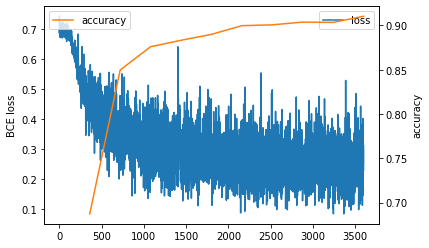

In [ ]:
xs = np.arange(len(train_loader), len(loss_history) + len(train_loader), len(train_loader))

plt.plot(loss_history, label="loss")
plt.ylabel("BCE loss")
plt.legend()
plt.twinx()
plt.plot(xs, train_acc_history, label="accuracy", c="C1")
plt.ylabel("accuracy")
plt.legend()
plt.show()

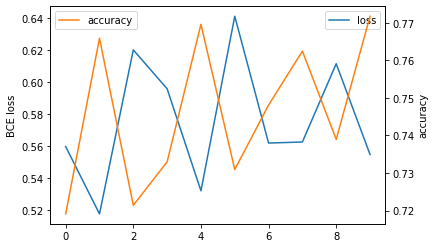

In [ ]:
eval_loss_history = [x.cpu() for x in eval_loss_history]
plt.plot(eval_loss_history, label="loss")
plt.legend()
plt.ylabel("BCE loss")
plt.twinx()
plt.plot(eval_acc_history, c="C1", label="accuracy")
plt.ylabel("accuracy")
plt.legend()
plt.show()